# 3.	This is question is stated in the file “Session 3 - Stock Price Predict - LSTM.ipynb”. In the example, we use the last 60 days prices to predict the closing price for next day. Modify the program to perform the following task: model using LSTM deep learning algorithm.

a.	Use past 60 days price to predict the price in one week (5 days). **You can choose any stock.**

Step1: loading the packages

In [2]:

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader import data as pdr

from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor


#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

%matplotlib inline


import importlib.util
import sys

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance



module 'yfinance' is installed


Step 2: Loading the Data 

For this case study, other than the historical data of Stocks, the independent variables used are the following potentially correlated assets:

1. historical stock prices: 'AAPL','AMZN','GOOGL','META', 'MCD', 'GM', 'TSLA','PFE'
2. 'DEXJPUS': This represents the exchange rate between the Japanese Yen (JPY) and the U.S. dollar (USD). Specifically, it shows the number of JPY that one USD can buy.
'DEXUSUK': This represents the exchange rate between the U.S. dollar (USD) and the British pound (GBP), also known as the "cable". Specifically, it shows the number of GBP that one USD can buy.
3.Indices: S&P 500, Dow Jones and VIX

In [2]:

import yfinance as yf

start_date = '2017-01-01'
end_date = '2021-12-31'
#Choose One Stocks 
stocks = ['AMZN']
df = yf.download(stocks, start_date, end_date )
df.head(5)



ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

[*********************100%***********************]  1 of 1 completed


In [3]:
df.shape

(1258, 6)

3. Visualize the data

Text(0, 0.5, 'Stock Price ($)')

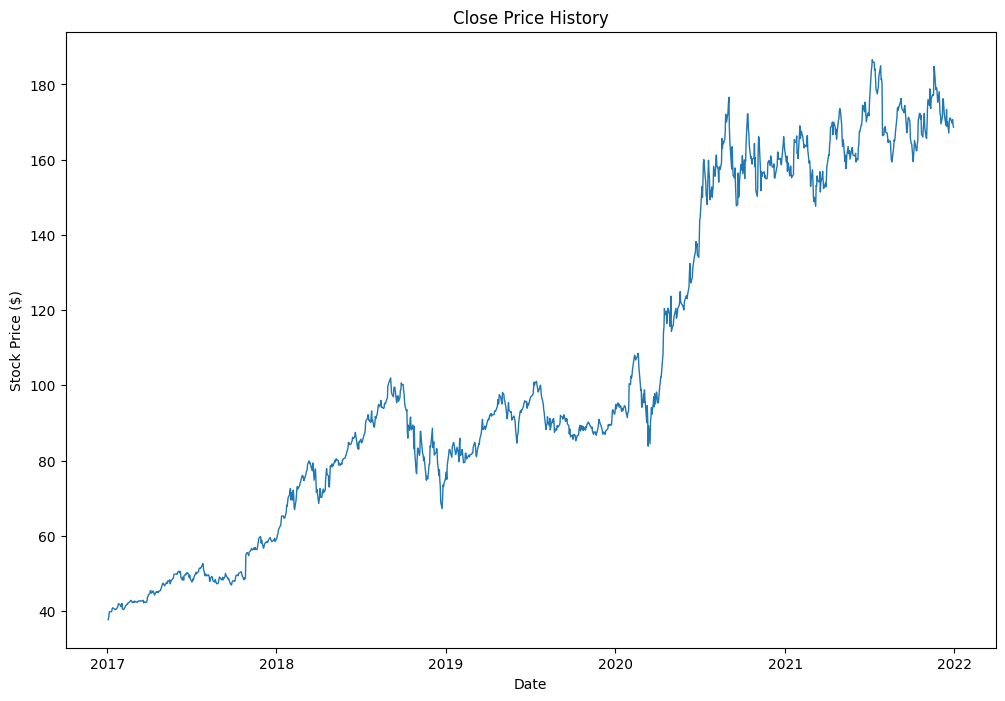

In [4]:
plt.figure(figsize=(12,8))
plt.title('Close Price History')
plt.plot(df['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

# 4. Prepare the Data

In [6]:
data=df.filter(['Close'])

In [7]:
#convert to numpy aarray
dataset=data.values
#We use 80 of the data for training
train_pct=0.8  
train_data_len=math.ceil(len(dataset)*train_pct)

In [8]:
dataset.shape

(1258, 1)

In [9]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

The window we use in n_priod as input and 5 days lag as target.

In [10]:
#creating target variable with 5 days lag
n_period=60
n_forecast_period = 5
#training dataset
train_data=scaled_data[0:train_data_len]
x_train=[]
y_train=[]

for i in range(n_period, train_data_len-n_forecast_period):
    x_train.append(scaled_data[i-n_period:i,0])
    y_train.append(scaled_data[i+n_forecast_period,0])
#Test dataset
x_test=[]
y_test=[]    

for i in range(train_data_len-n_forecast_period+1, len(scaled_data)-n_forecast_period):
    x_test.append(scaled_data[i-n_period:i,0])
    y_test.append(scaled_data[i+n_forecast_period,0])

In [11]:
x_train[0:2]

[array([0.        , 0.00117876, 0.0089934 , 0.01421213, 0.01452445,
        0.0141819 , 0.01522968, 0.02013944, 0.02131482, 0.01882301,
        0.01807077, 0.01859465, 0.01835621, 0.02156335, 0.02309472,
        0.02782313, 0.02870635, 0.02757127, 0.02576117, 0.02344396,
        0.02642274, 0.02897502, 0.0189842 , 0.01812449, 0.01975661,
        0.02217791, 0.02273202, 0.02478056, 0.02782648, 0.02777947,
        0.02989851, 0.03038212, 0.03069444, 0.03451275, 0.03423402,
        0.03308551, 0.03075153, 0.03189332, 0.03068435, 0.03338439,
        0.031984  , 0.03230975, 0.03121161, 0.03101346, 0.03251797,
        0.03335753, 0.03317619, 0.03389149, 0.03319968, 0.03334744,
        0.03349858, 0.03312581, 0.03469075, 0.03006644, 0.03169855,
        0.03147018, 0.03087577, 0.03128212, 0.03436499, 0.04051731]),
 array([0.00117876, 0.0089934 , 0.01421213, 0.01452445, 0.0141819 ,
        0.01522968, 0.02013944, 0.02131482, 0.01882301, 0.01807077,
        0.01859465, 0.01835621, 0.02156335, 0.

In [12]:
x_train[0:1]

[array([0.        , 0.00117876, 0.0089934 , 0.01421213, 0.01452445,
        0.0141819 , 0.01522968, 0.02013944, 0.02131482, 0.01882301,
        0.01807077, 0.01859465, 0.01835621, 0.02156335, 0.02309472,
        0.02782313, 0.02870635, 0.02757127, 0.02576117, 0.02344396,
        0.02642274, 0.02897502, 0.0189842 , 0.01812449, 0.01975661,
        0.02217791, 0.02273202, 0.02478056, 0.02782648, 0.02777947,
        0.02989851, 0.03038212, 0.03069444, 0.03451275, 0.03423402,
        0.03308551, 0.03075153, 0.03189332, 0.03068435, 0.03338439,
        0.031984  , 0.03230975, 0.03121161, 0.03101346, 0.03251797,
        0.03335753, 0.03317619, 0.03389149, 0.03319968, 0.03334744,
        0.03349858, 0.03312581, 0.03469075, 0.03006644, 0.03169855,
        0.03147018, 0.03087577, 0.03128212, 0.03436499, 0.04051731])]

In [13]:
y_train[:1]

[0.0485636974157691]

In [14]:
y_train[:2]

[0.0485636974157691, 0.04742187854096125]

In [15]:
#Convert numpy array
x_train, y_train=np.array(x_train), np.array(y_train)

In [16]:
x_train.shape

(942, 60)

In [17]:
y_train.shape

(942,)

In [18]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(942, 60, 1)

In [19]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
          

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

942/942 [==============================] - 32s 27ms/step - loss: 0.0034


In [21]:
#Test
test_data=scaled_data[train_data_len-60:,:]
x_test=[]
y_test=dataset[train_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
               
x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [23]:
x_test.shape

(251, 60, 1)

Prediction Error 

In [24]:
predictions=model.predict(x_test)

8/8 [==============================] - 1s 13ms/step


In [25]:
predictions=scaler.inverse_transform(predictions)

In [26]:
predictions.shape

(251, 1)

In [27]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

7.809381431792362

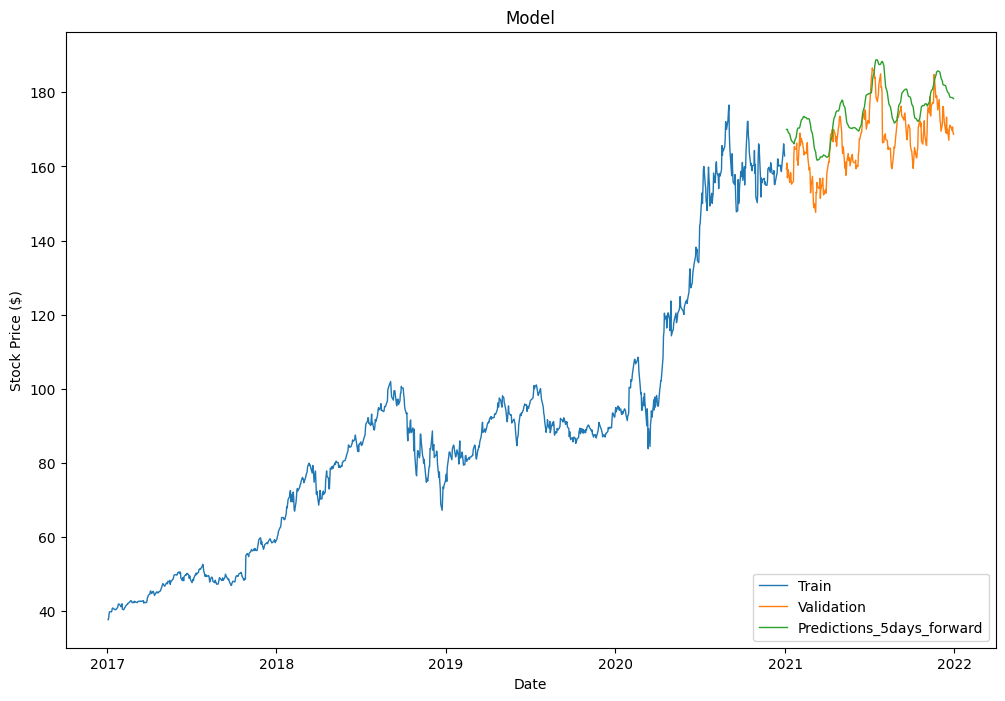

In [28]:
#plot the result
train=data[:train_data_len]
valid=data[train_data_len:]
valid=valid.assign(Predictions_5days_forward=predictions)
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train['Close'], lw=1)
plt.plot(valid[['Close','Predictions_5days_forward']], lw=1)
plt.legend(['Train','Validation', 'Predictions_5days_forward'],loc='lower right')
plt.show()

In [29]:
valid

,Close,Predictions_5days_forward
Date,,
2021-01-04,159.331497,169.984421
2021-01-05,160.925507,170.032013
2021-01-06,156.919006,169.995209
2021-01-07,158.108002,169.600327
2021-01-08,159.134995,169.151932
...,...,...
2021-12-23,171.068497,178.641769
2021-12-27,169.669495,178.584335
2021-12-28,170.660995,178.481552


In [30]:
# Get the quote
quote = yf.download('AMZN', start='2017-01-01', end='2022-12-31')
quote

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,37.683498,70422000
2017-01-04,37.919498,37.984001,37.709999,37.859001,37.859001,50210000
2017-01-05,38.077499,39.119999,38.013000,39.022499,39.022499,116602000
2017-01-06,39.118000,39.972000,38.924000,39.799500,39.799500,119724000
2017-01-09,39.900002,40.088501,39.588501,39.846001,39.846001,68922000
...,...,...,...,...,...,...
2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700
2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000
2022-12-28,82.800003,83.480003,81.690002,81.820000,81.820000,58228600


In [31]:
quote_df=quote.filter(['Close'])
quote_df

,Close
Date,
2017-01-03,37.683498
2017-01-04,37.859001
2017-01-05,39.022499
2017-01-06,39.799500
2017-01-09,39.846001
...,...
2022-12-23,85.250000
2022-12-27,83.040001
2022-12-28,81.820000


In [32]:
#last 60 days
last_60_days=quote_df[-60:].values
last_60_days_scaled=scaler.transform(last_60_days)

In [33]:
X_test=[]
X_test.append(last_60_days_scaled)
X_test=np.array(X_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_price=model.predict(X_test)
predicted_prce=scaler.inverse_transform(predicted_price)
print(predicted_prce)

1/1 [==============================] - 0s 35ms/step
[[91.93737]]


In [34]:


# Get the quote
quote = yf.download('AMZN', start='2023-01-02', end='2023-01-08')
quote

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,85.459999,86.959999,84.209999,85.820000,85.820000,76706000
2023-01-04,86.550003,86.980003,83.360001,85.139999,85.139999,68885100
2023-01-05,85.330002,85.419998,83.070000,83.120003,83.120003,67930800
2023-01-06,83.029999,86.400002,81.430000,86.080002,86.080002,83303400


## b.	Use your prediction to generate trading signals for the testing period (20% of you dataset): if the predicted price is higher than the current price (you can specify a threshold), you should buy one share; if it is lower than the current price, you can short one share.

In [39]:
#Trading Strategies with 20% thresholds
valid['current_price']=data.values[train_data_len-5:len(data)-5]
valid['delta']=(valid['current_price']-valid['Predictions_5days_forward'])/valid['current_price']
valid['sell_signal']=[1 if x>0.2 else 0 for x in valid['delta']]
valid['buy_signal']=[1 if x<-0.2 else 0 for x in valid['delta']]
valid['pnl_buy']= (valid['Close'] - valid['current_price'])* valid['buy_signal']
valid['pnl_shortsell']= (valid['current_price'] - valid['Close'])* valid['sell_signal']
valid

,Close,Predictions_5days_forward,current_price,delta,sell_signal,buy_signal,pnl_buy,pnl_shortsell
Date,,,,,,,,
2021-01-04,159.331497,169.984421,158.634506,-0.071548,0,0,0.0,-0.0
2021-01-05,160.925507,170.032013,164.197998,-0.035530,0,0,-0.0,0.0
2021-01-06,156.919006,169.995209,166.100006,-0.023451,0,0,-0.0,0.0
2021-01-07,158.108002,169.600327,164.292496,-0.032307,0,0,-0.0,0.0
2021-01-08,159.134995,169.151932,162.846497,-0.038720,0,0,-0.0,0.0
...,...,...,...,...,...,...,...,...
2021-12-23,171.068497,178.641769,168.871002,-0.057859,0,0,0.0,-0.0
2021-12-27,169.669495,178.584335,170.017502,-0.050388,0,0,-0.0,0.0
2021-12-28,170.660995,178.481552,167.078995,-0.068247,0,0,0.0,-0.0


# **c.	Assume that you will always close your position in one week, calculate your accumulated profit and loss for the testing data**

In [45]:
# P&L on the testing data is $15 by following the trading strategy the cumulated 
pnl = sum(valid['pnl_buy'])+sum(valid['pnl_shortsell'])
pnl

0.0

# **d.	Repeat a)-c), adding S&P 500 to the features for the prediction (as I explained in the class).**

# **e.	Repeat a)-c), adding S&P 500  and the VIX index to the features for the prediction (as I explained in the class).**

In [22]:
# Get the data by webscapping using pandas datareader
return_period = 21

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance

import yfinance as yf

stk_tickers = ['AMZN','IBM', 'GOOGL']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

module 'yfinance' is installed


In [23]:
stk_data = yf.download(stk_tickers)
idx_data = web.DataReader(idx_tickers, 'fred')

[*********************100%***********************]  3 of 3 completed


In [26]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'AMZN')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'


X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'AMZN')]).diff(i) for i in [21, 63, 126,252]], axis=1).dropna()
X4.columns = ['1M', '3M', '6M', '1Y']

X = pd.concat([X1, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna()
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [27]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
dataset.shape

(1174, 10)

In [29]:
# peek at data
pd.set_option('display.width', 100)
dataset.head(4)

,AMZN_pred,GOOGL,IBM,SP500,DJIA,VIXCLS,1M,3M,6M,1Y
2018-07-09,0.068587,0.028555,-0.006695,0.001848,-0.021558,0.041019,0.029007,0.212516,0.347007,0.574791
2018-07-10,0.079086,0.029943,-0.009833,0.004247,-0.016029,0.023210,0.034482,0.193633,0.335012,0.559184
2018-07-11,0.078606,0.026433,-0.011251,-0.004614,-0.024802,0.099427,0.038261,0.206859,0.337168,0.568356
2018-07-12,0.048710,0.045184,-0.002864,0.008131,-0.011025,-0.028215,0.056014,0.215379,0.359306,0.579418


In [30]:
# types
pd.set_option('display.max_rows', 500)
dataset.dtypes

AMZN_pred    float64
GOOGL        float64
IBM          float64
SP500        float64
DJIA         float64
VIXCLS       float64
1M           float64
3M           float64
6M           float64
1Y           float64
dtype: object

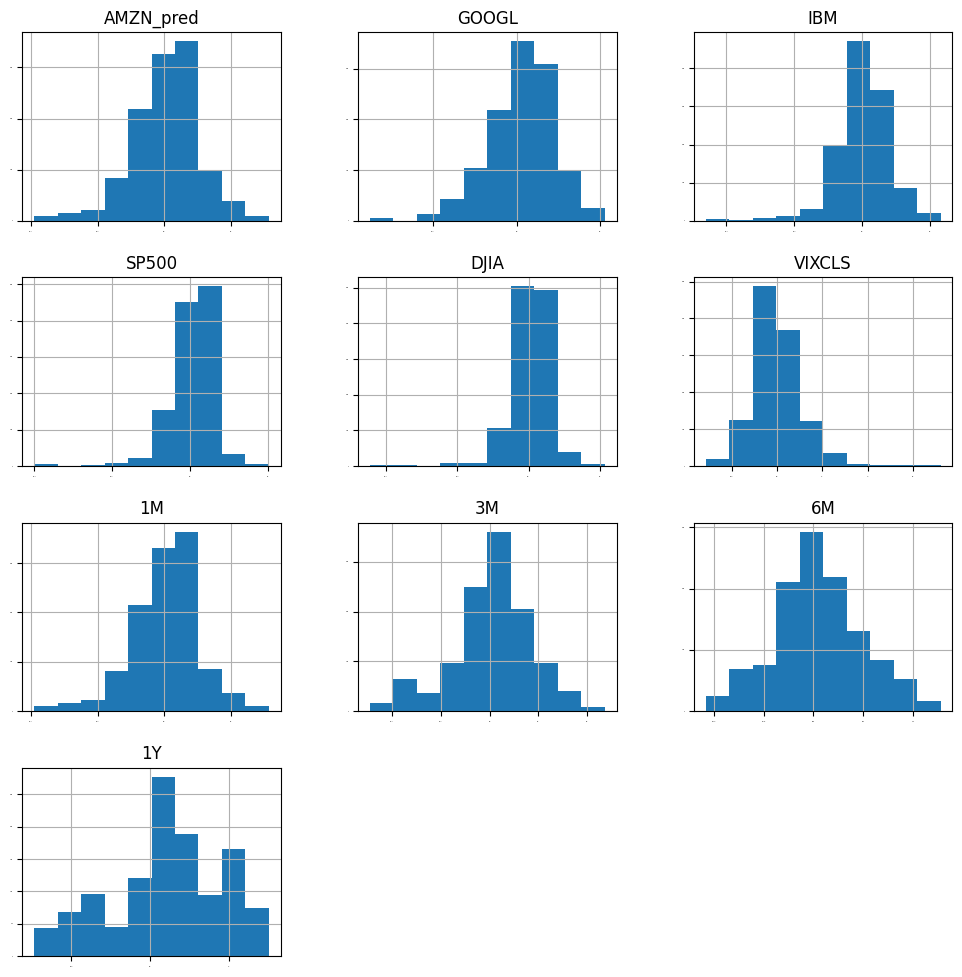

In [31]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

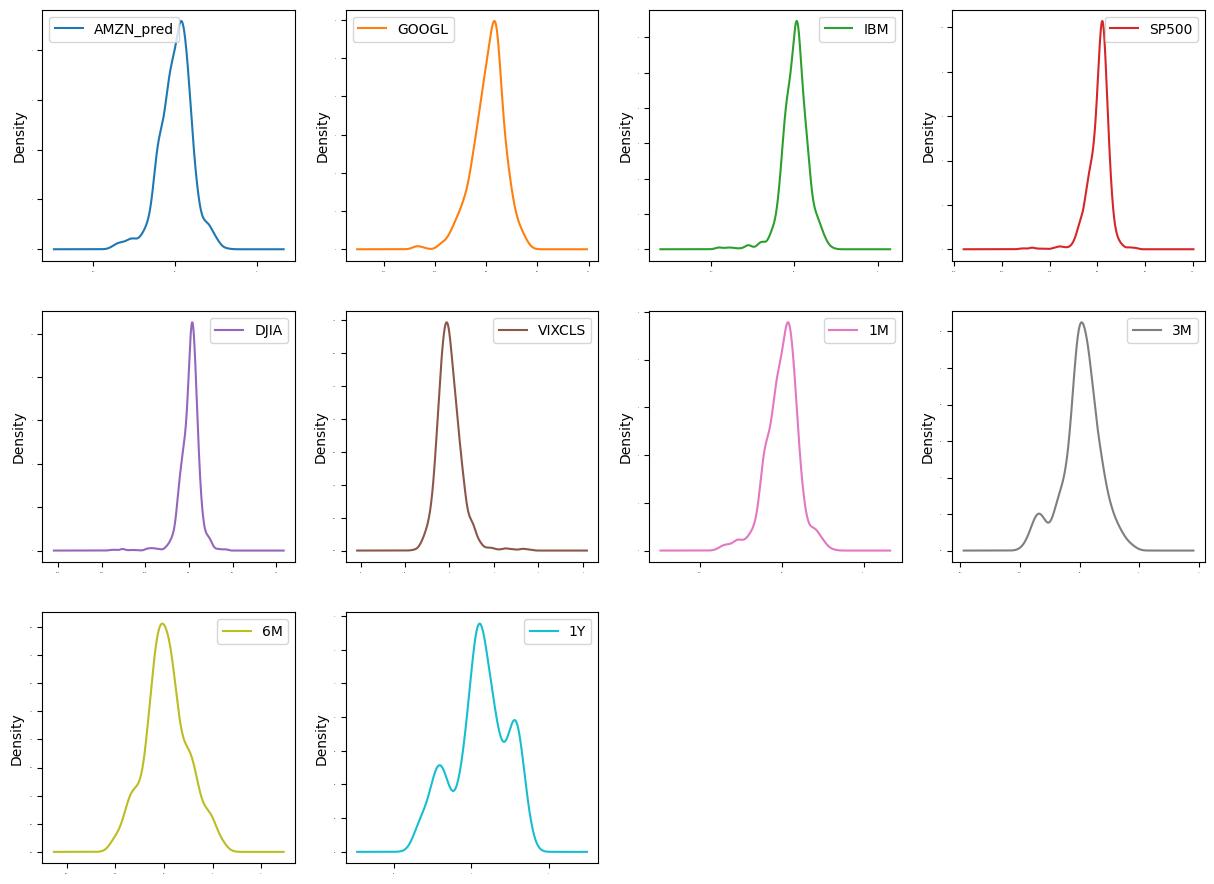

In [32]:
# density
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
plt.show()

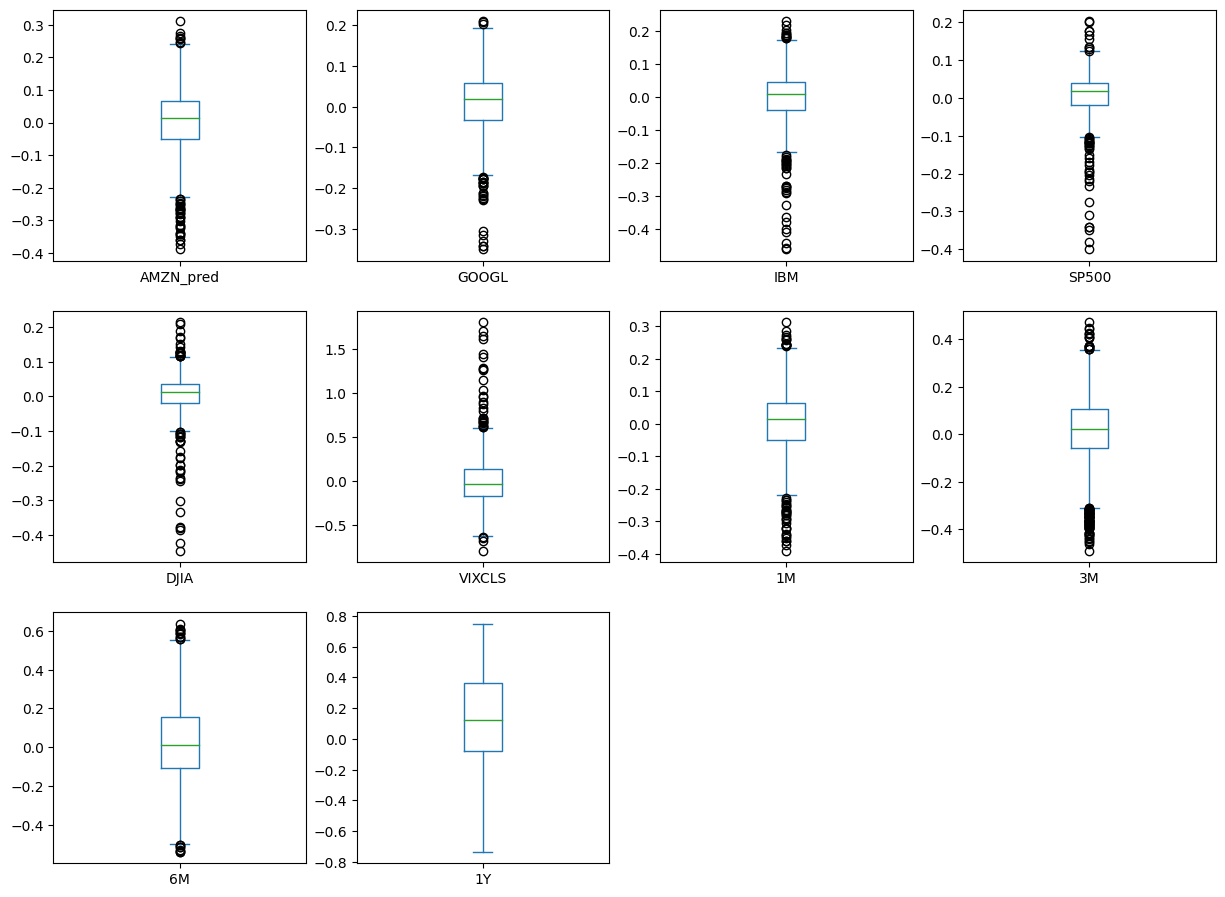

In [33]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

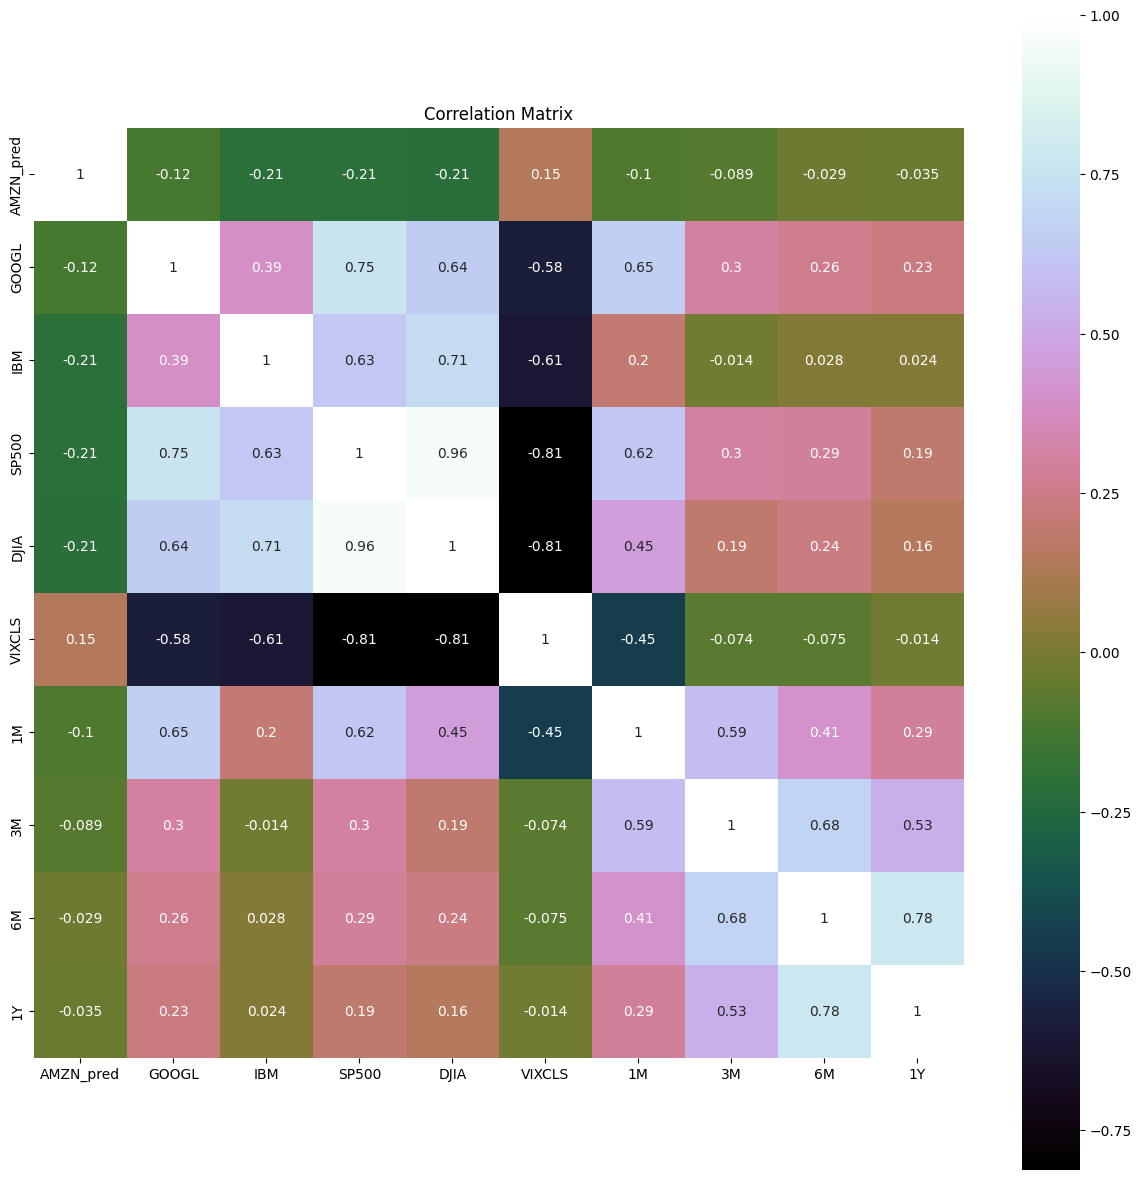

In [34]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [35]:
Y

2018-07-09    0.068587
2018-07-10    0.079086
2018-07-11    0.078606
2018-07-12    0.048710
2018-07-13    0.044852
                ...   
2023-05-01    0.166851
2023-05-02    0.169486
2023-05-03    0.181276
2023-05-04    0.186320
2023-05-05    0.180885
Name: AMZN_pred, Length: 1174, dtype: float64

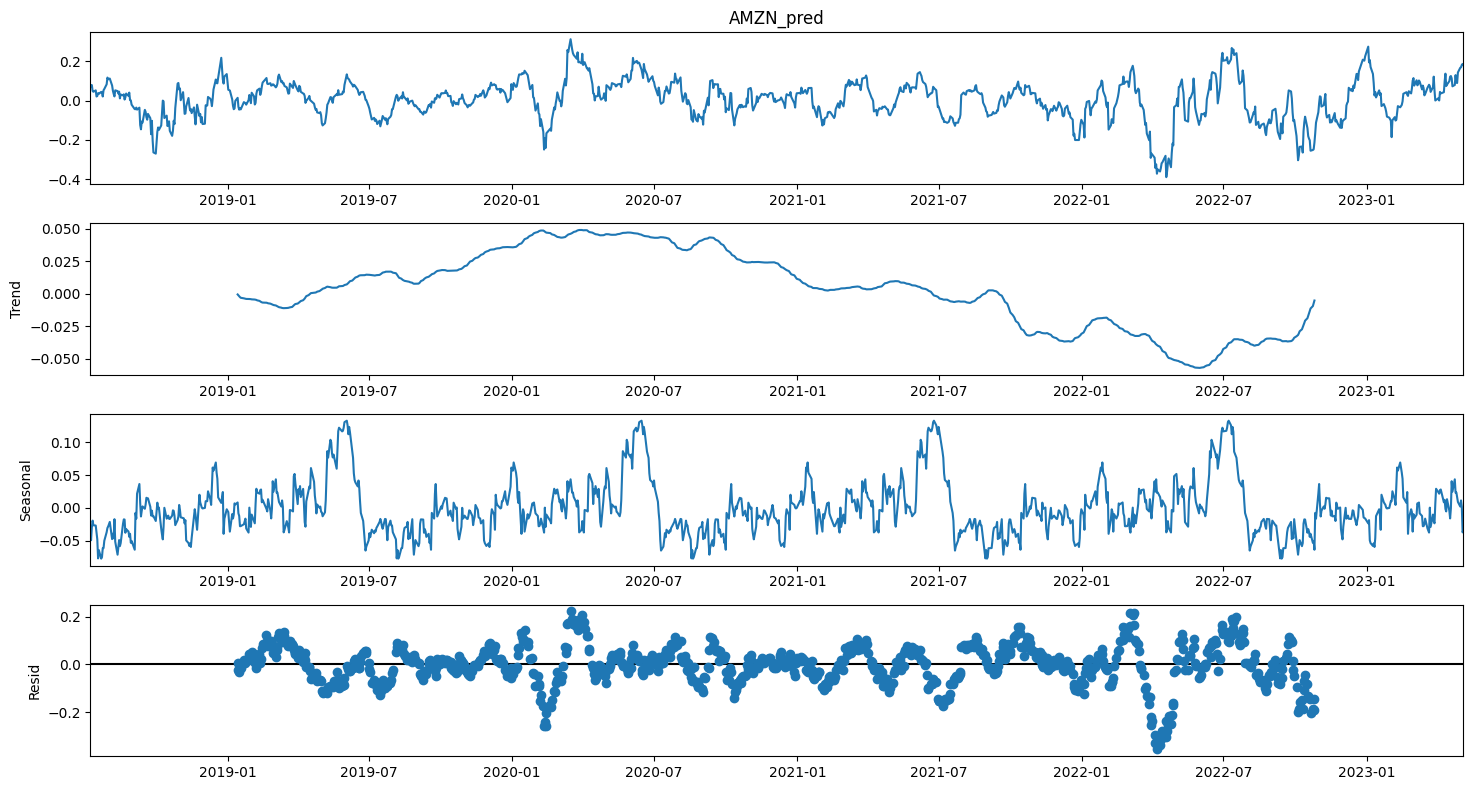

In [37]:
Y= dataset["AMZN_pred"]
res = sm.tsa.seasonal_decompose(Y,model='additive', period=252)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [38]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [39]:
Y= dataset["AMZN_pred"]
X = dataset.loc[:, dataset.columns != 'AMZN_pred']

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,  f_regression

bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
DJIA,56.149108
SP500,54.452690
IBM,53.276986
VIXCLS,25.941128
GOOGL,17.387807
1M,12.666503
3M,9.331321
1Y,1.421427
6M,0.980531


In [41]:
fit.pvalues_

array([3.27226576e-05, 5.33012040e-13, 3.00804180e-13, 1.31937930e-13,
       4.09872771e-07, 3.87157581e-04, 2.30356922e-03, 3.22272224e-01,
       2.33409982e-01])

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
rescaledX.head(5)

,0,1,2,3,4,5,6,7,8
0,0.675545,0.657083,0.666614,0.642578,0.319343,0.596544,0.730231,0.752814,0.882030
1,0.678018,0.652542,0.670594,0.650983,0.312449,0.604348,0.710610,0.742644,0.871522
2,0.671767,0.650490,0.655893,0.637648,0.341956,0.609736,0.724353,0.744472,0.877697
3,0.705163,0.662628,0.677037,0.658589,0.292540,0.635045,0.733206,0.763241,0.885146
4,0.715995,0.662316,0.674731,0.665905,0.305375,0.642888,0.755437,0.755976,0.895213


In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
StandardisedX.head(5)

,0,1,2,3,4,5,6,7,8
0,0.232696,-0.118101,-0.085922,-0.470960,0.132689,0.263722,1.233796,1.447994,1.315887
1,0.250300,-0.158010,-0.043844,-0.374068,0.069628,0.319200,1.117713,1.393917,1.271681
2,0.205803,-0.176047,-0.199268,-0.527799,0.339512,0.357498,1.199022,1.403637,1.297662
3,0.443525,-0.069368,0.024278,-0.286382,-0.112470,0.537409,1.251394,1.503438,1.328995
4,0.520633,-0.072108,-0.000099,-0.202047,0.004927,0.593166,1.382917,1.464807,1.371346


In [44]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X)
NormalizedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
NormalizedX.head(5)

,0,1,2,3,4,5,6,7,8
0,0.040390,-0.009471,0.002614,-0.030494,0.058020,0.041030,0.300599,0.490834,0.813028
1,0.043892,-0.014414,0.006225,-0.023495,0.034022,0.050545,0.283833,0.491069,0.819667
2,0.037673,-0.016036,-0.006576,-0.035348,0.141705,0.054530,0.294819,0.480535,0.810028
3,0.062817,-0.003981,0.011304,-0.015327,-0.039226,0.077874,0.299430,0.499525,0.805536
4,0.069837,-0.004195,0.009183,-0.008462,0.006727,0.083800,0.322541,0.477786,0.809672


In [45]:
# split out validation dataset for the end

test_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
# X_train, X_test, Y_train, Y_vtest = train_test_split(X, Y, test_size=test_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.

train_size = int(len(X) * (1-test_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [46]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
#scoring = 'r2'

In [47]:
X_train_LSTM, X_test_LSTM = np.array(X_train), np.array(X_test)
Y_train_LSTM, Y_test_LSTM = np.array(Y_train), np.array(Y_test)
X_train_LSTM= X_train_LSTM.reshape((X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_test_LSTM= X_test_LSTM.reshape((X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))
print(X_train_LSTM.shape, Y_train_LSTM.shape, X_test_LSTM.shape, Y_test_LSTM.shape)

(939, 1, 9) (939,) (235, 1, 9) (235,)


In [48]:
# design network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM,\
                              Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),\
                              epochs=50, batch_size=72, verbose=0, shuffle=False)

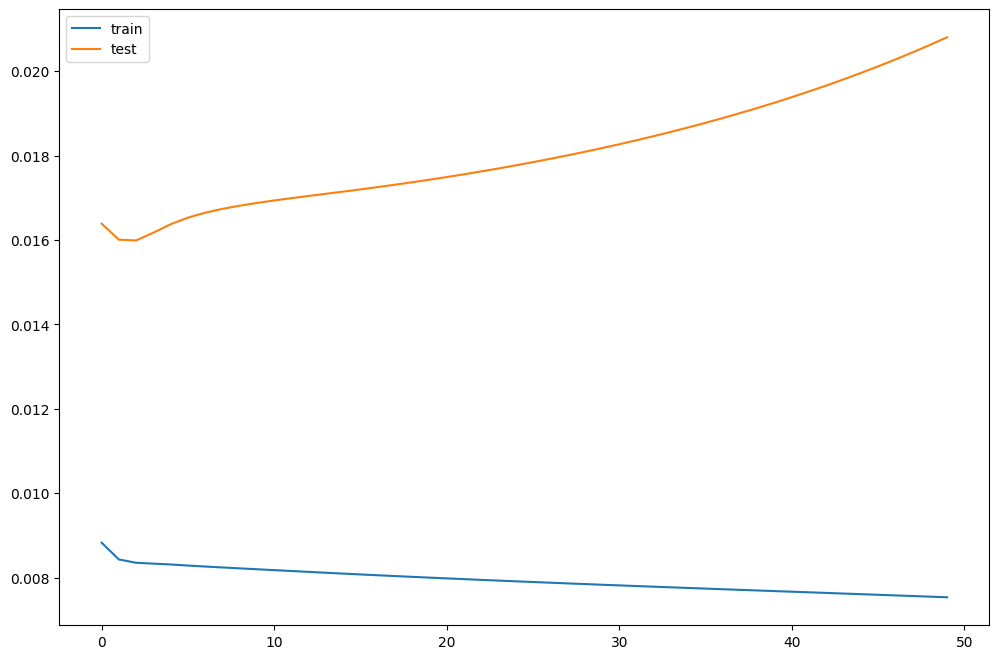

In [49]:
#Visual plot to check if the error is reducing
plt.plot(LSTMModel_fit.history['loss'], label='train')
plt.plot(LSTMModel_fit.history['val_loss'], label='test')
plt.legend()
plt.show()

In [53]:
#Running deep learning models and performing cross validation takes time
#Set the following Flag to 0 if the Deep LEarning Models Flag has to be disabled
EnableDeepLearningRegreesorFlag = 0

def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        #The number of hidden layers can be increased
        model.add(Dense(2, activation=activation))
        # Final output layer
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model   

In [55]:
#Add Deep Learning Regressor
if ( EnableDeepLearningRegreesorFlag == 1):
    models.append(('DNN', KerasRegressor(build_fn=create_model, epochs=100, batch_size=100, verbose=1)))    

In [57]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [58]:
names = []
kfold_results = []
test_results = []
train_results = []

print("Model,\t CrossValMean,\t CrossValSTD,\t train_MSE,\t test_MSE")
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

Model,	 CrossValMean,	 CrossValSTD,	 train_MSE,	 test_MSE
LR: 	  0.008011 	  (0.001274) 	   0.007838 	   0.019965
LASSO: 	  0.008683 	  (0.001405) 	   0.008670 	   0.014959
EN: 	  0.008683 	  (0.001405) 	   0.008670 	   0.014959
KNN: 	  0.002444 	  (0.000726) 	   0.001269 	   0.033166
CART: 	  0.004454 	  (0.001252) 	   0.000000 	   0.050145
SVR: 	  0.004261 	  (0.000611) 	   0.003761 	   0.053904
MLP: 	  0.006900 	  (0.001149) 	   0.005989 	   0.031395


In [59]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

train_results.append(error_Training_LSTM)
test_results.append(error_Test_LSTM)
names.append("LSTM")

print('For the final model:')
print('MSE:\t ',error_Test_LSTM, '\t RMSE:\t ', np.sqrt(error_Test_LSTM))

8/8 [==============================] - 0s 2ms/step
For the final model:
MSE:	  0.020804782977193043 	 RMSE:	  0.1442386320553306


In [61]:
#Grid Search for LSTM Model

# evaluate an LSTM model for a given order (p,d,q)
def evaluate_LSTM_model(neurons=12, learn_rate = 0.01, momentum=0):
    #predicted = list()     
    LSTMModel = create_LSTMmodel(neurons, learn_rate, momentum)
    LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM,epochs=50, batch_size=72, verbose=0, shuffle=False)
    predicted = LSTMModel.predict(X_test_LSTM)
    error = mean_squared_error(predicted, Y_test)
    return error

# evaluate combinations of different variables of LSTM Model
def evaluate_combinations_LSTM(neurons, learn_rate, momentum): 
    best_score, best_cfg = float("inf"), None
    for n in neurons:
        for l in learn_rate:
            for m in momentum:
                combination = (n,l,m)                
                try:
                    mse = evaluate_LSTM_model(n,l,m)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, combination
                    print('LSTM%s MSE=%.7f' % (combination,mse))
                except:
                    continue
    print('Best LSTM%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
neurons = [1, 5]
learn_rate = [0.001, 0.3]
momentum = [0.0, 0.9]
#Other Parameters can be modified as well
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
warnings.filterwarnings("ignore")
evaluate_combinations_LSTM(neurons,learn_rate,momentum) 

8/8 [==============================] - 0s 2ms/step
LSTM(1, 0.001, 0.0) MSE=0.0197160
8/8 [==============================] - 0s 1ms/step
LSTM(1, 0.001, 0.9) MSE=0.0218249
8/8 [==============================] - 0s 2ms/step
LSTM(1, 0.3, 0.0) MSE=0.0212806
8/8 [==============================] - 0s 2ms/step
LSTM(1, 0.3, 0.9) MSE=0.0198540
8/8 [==============================] - 0s 2ms/step
LSTM(5, 0.001, 0.0) MSE=0.0207139
8/8 [==============================] - 0s 2ms/step
LSTM(5, 0.001, 0.9) MSE=0.0199001
8/8 [==============================] - 0s 3ms/step
LSTM(5, 0.3, 0.0) MSE=0.0208224
8/8 [==============================] - 0s 2ms/step
LSTM(5, 0.3, 0.9) MSE=0.0203455
Best LSTM(1, 0.001, 0.0) MSE=0.0197160


In [65]:
import tensorflow as tf
def create_best_LSTMmodel(neurons=1, learn_rate=0.001, momentum=0.0):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

best_model = create_best_LSTMmodel()

# Train the model using the best parameters
best_model.fit(X_train_LSTM, Y_train_LSTM, epochs=50, batch_size=72, verbose=0, shuffle=False)

# Predict on the test set
predictions = best_model.predict(X_test_LSTM)

# Calculate the mean squared error on the test set
mse = mean_squared_error(Y_test_LSTM, predictions)
print('Test MSE: %.7f' % mse)

8/8 [==============================] - 0s 1ms/step
Test MSE: 0.0251507


In [66]:
predictions

array([[-0.03299353],
       [-0.02557564],
       [-0.02140062],
       [-0.03692251],
       [-0.06415492],
       [-0.06113853],
       [-0.10391237],
       [-0.08475471],
       [-0.08189961],
       [-0.05983482],
       [-0.04264874],
       [-0.00119514],
       [-0.06527573],
       [-0.01089476],
       [-0.05190801],
       [-0.03589523],
       [-0.04281472],
       [-0.03697889],
       [ 0.01601556],
       [-0.00666814],
       [ 0.00132995],
       [-0.04196123],
       [-0.0215241 ],
       [-0.00611415],
       [-0.02249238],
       [-0.00836337],
       [ 0.01880553],
       [ 0.01333904],
       [-0.02537075],
       [-0.03191144],
       [-0.02862888],
       [-0.01689508],
       [-0.00158473],
       [ 0.00638656],
       [-0.01434944],
       [-0.02645098],
       [-0.05844909],
       [-0.03841905],
       [-0.00255511],
       [-0.04926283],
       [-0.03824675],
       [-0.01593779],
       [-0.01442454],
       [-0.01956349],
       [ 0.0036931 ],
       [-0

In [68]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [69]:
# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation) #in case the data is scaled.
#predictions = model.predict(rescaledValidationX)
predictions = model.predict(X_test)
result = mean_squared_error(Y_test, predictions)
print(result)

0.03139475347404955
